# Content-based recommender using DSSM
An example of how to build a Deep Structured Semantic Model (DSSM) for incorporating complex content-based features into a recommender system.  See [Learning Deep Structured Semantic Models for Web Search using Clickthrough Data](https://www.microsoft.com/en-us/research/publication/learning-deep-structured-semantic-models-for-web-search-using-clickthrough-data/).  This example does not attempt to provide a datasource or train a model, but merely show how to structure a complex DSSM network.

In [1]:
import mxnet as mx
import symbol_alexnet as alexnet
import recotools

/home/ec2-user/anaconda3/envs/mxnet_p27/lib/python2.7/site-packages/urllib3/contrib/pyopenssl.py:46: DeprecationWarning: OpenSSL.rand is deprecated - you should use os.urandom instead
  import OpenSSL.SSL


In [2]:
# Define some constants
max_user = int(1e6)
title_vocab = int(1e5)
ngram_dimensions = int(1e8)

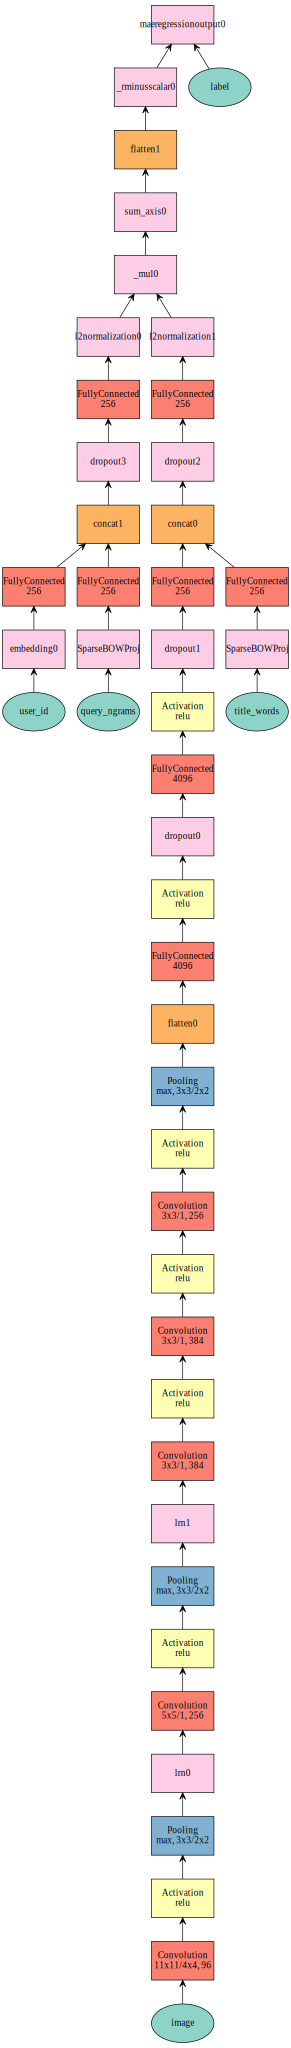

In [3]:
def dssm_recommender(k):
    # input variables
    title = mx.symbol.Variable('title_words')
    image = mx.symbol.Variable('image')
    queries = mx.symbol.Variable('query_ngrams')
    user = mx.symbol.Variable('user_id')
    label = mx.symbol.Variable('label')
    
    # Process content stack
    image = alexnet.features(image, 256)
    title = recotools.SparseBagOfWordProjection(data=title, vocab_size=title_vocab, 
                                    output_dim=k)
    title = mx.symbol.FullyConnected(data=title, num_hidden=k)
    content = mx.symbol.Concat(image, title)
    content = mx.symbol.Dropout(content, p=0.5)
    content = mx.symbol.FullyConnected(data=content, num_hidden=k)
    
    # Process user stack
    user = mx.symbol.Embedding(data=user, input_dim=max_user, output_dim=k) 
    user = mx.symbol.FullyConnected(data=user, num_hidden=k)
    queries = recotools.SparseBagOfWordProjection(data=queries, vocab_size=ngram_dimensions, 
                                            output_dim=k)
    queries = mx.symbol.FullyConnected(data=queries, num_hidden=k)
    user = mx.symbol.Concat(user,queries)
    user = mx.symbol.Dropout(user, p=0.5)
    user = mx.symbol.FullyConnected(data=user, num_hidden=k)
    
    # loss layer
    pred = recotools.CosineLoss(a=user, b=content, label=label)
    return pred

net1 = dssm_recommender(256)
mx.viz.plot_network(net1)